In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
btc_data = pd.read_csv("btc_data.csv")

In [3]:
btc_data.head()

,date,open,high,low,close
0,2022-02-02 02:24:00,28578.65,28592.38,28578.65,28589.82
1,2022-02-02 02:25:00,28589.22,28589.22,28574.78,28576.03
2,2022-02-02 02:26:00,28577.74,28577.74,28565.23,28573.16
3,2022-02-02 02:27:00,28570.55,28579.07,28561.58,28579.07
4,2022-02-02 02:28:00,28572.09,28576.29,28565.49,28565.49


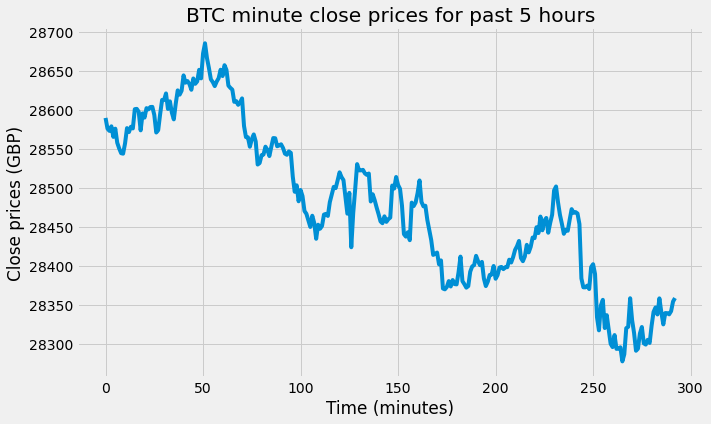

In [4]:
#Visualising the data
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xlabel('Time (minutes)')
plt.ylabel('Close prices (GBP)')
plt.plot(btc_data['close'])
plt.title('BTC minute close prices for past 5 hours')
plt.show()

<AxesSubplot:ylabel='Density'>

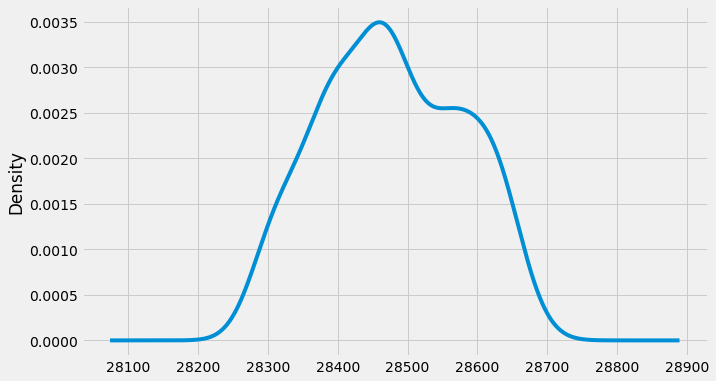

In [5]:
# We can see the probability distribution of the close prices 
btc_data['close'].plot(kind='kde')

ADF (Augmented Dickey-Fuller) Test

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:

Null Hypothesis: The series has a unit root (value of a =1)

Alternate Hypothesis: The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.

If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

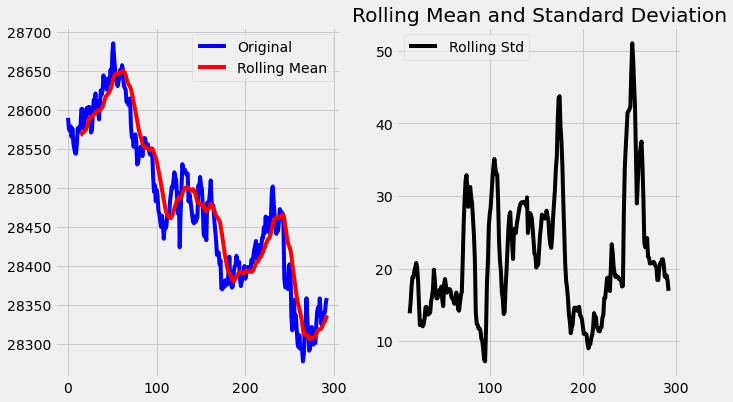

Results of dickey fuller test
Test Statistics                 -1.307663
p-value                          0.625659
No. of lags used                 0.000000
Number of observations used    292.000000
critical value (1%)             -3.452945
critical value (5%)             -2.871490
critical value (10%)            -2.572071
dtype: float64


In [6]:
# Testing for stationarity
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(15).mean()
    rolstd = timeseries.rolling(15).std()
    # Plot rolling statistics:
    plt.subplot(1, 2, 1)
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
      
    plt.subplot(1, 2, 2)    
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    plt.show(block=False)

    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # The above test method from the library will give us a direct result
    # So I am manually writing out the values given to give a more thorough explanation
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(btc_data['close'])

We can see the decreasing mean and fluctuating standard deviation, and p > 0.05, so our data is not stationary.

In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.

So let us separate trend and seasonality from the time series.

<Figure size 720x432 with 0 Axes>

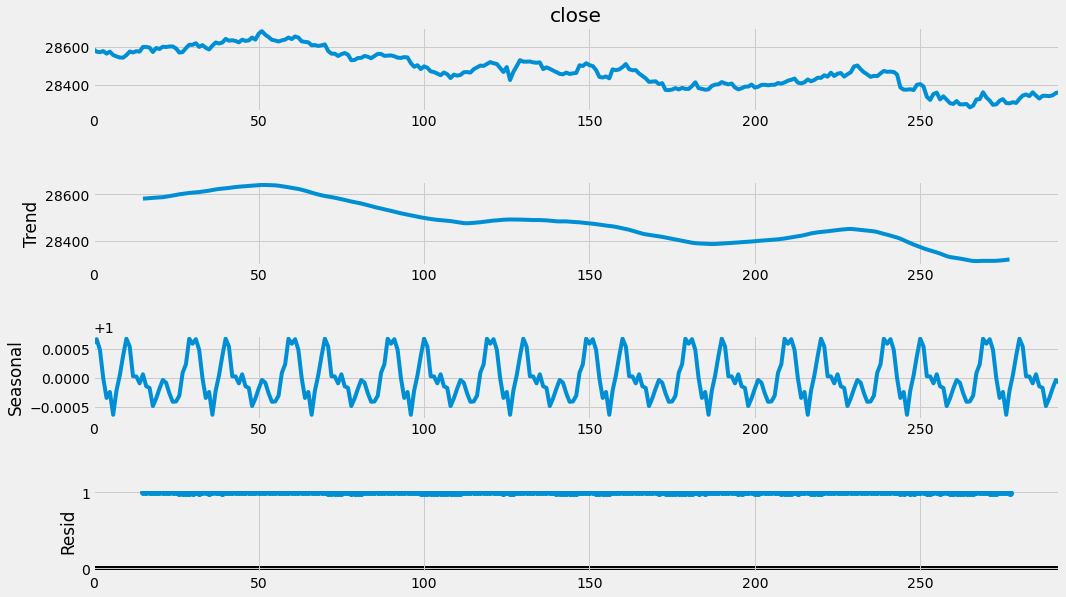

In [7]:
# Decompose the data to see trend and seasonality
result = seasonal_decompose(btc_data['close'], model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

I'll start by taking a log of the series to reduce the magnitude of the values and the rising trend. Then, I'll recalculate the rolling average (15 minute calculation intervals).

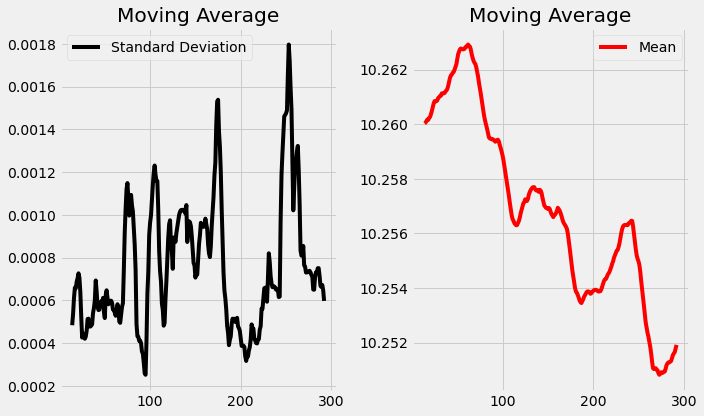

In [8]:
df_log = np.log(btc_data['close'])

moving_avg = df_log.rolling(15).mean()
std_dev = df_log.rolling(15).std()

plt.subplot(1, 2, 1)
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.legend(loc='best')
plt.title('Moving Average')


plt.subplot(1, 2, 2)  
plt.plot(moving_avg, color="red", label = "Mean")
plt.title('Moving Average')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

Now I will use an ARIMA model... first, let's split the data into train/test sets

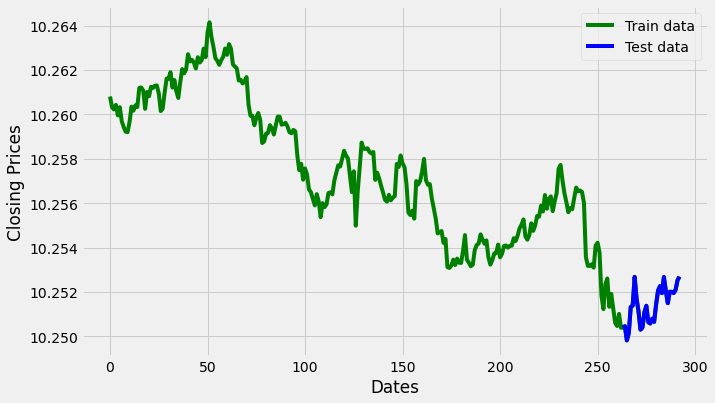

In [9]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

I will use auto ARIMA to get the values of p, d and q since it doesn't require plotting ACF and PAC graphs.

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3149.550, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3147.717, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3147.714, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3150.262, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3145.550, Time=0.53 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.531 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  260
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1576.131
Date:                Wed, 02 Feb 2022   AIC                          -3150.262
Time:                        10:35:16   BIC                          -3146.705
Sample:                             0   HQIC                         -3148.832
                                - 260                                  

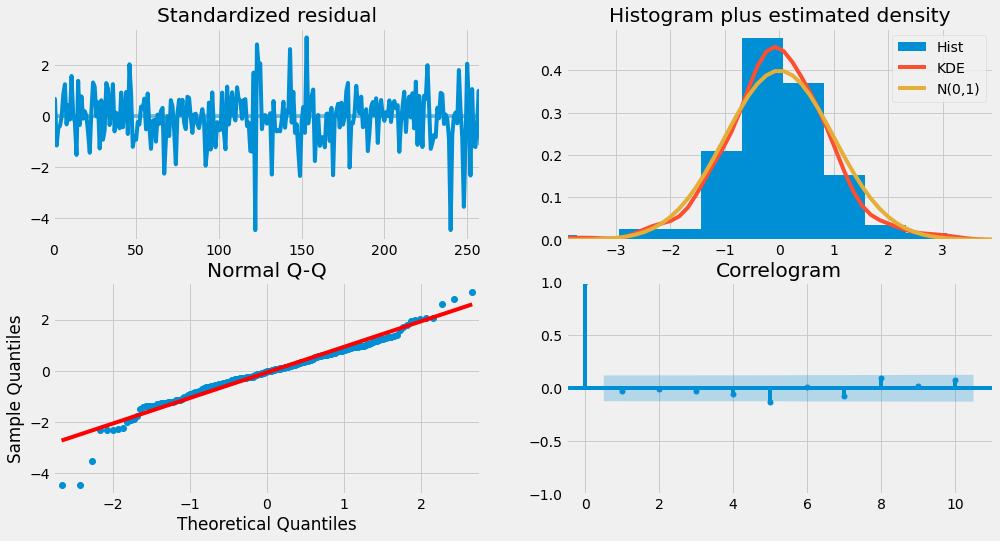

In [10]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

My analysis of the plots above:
    
**Standardized residual (top left):** 

The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

**History + estimated density (top right):** 

The density plot suggests normal distribution with mean zero.

**Normal Q-Q (bottom left):** 

There is very little skew since all the dots fall almost perfectly within the red line.

**Correlogram (bottom right):** 

The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model, which is not the case here. 

**Overall**, it seems to be a good fit. Let’s start forecasting the stock prices.

Next, create an ARIMA model with provided optimal parameters p (0), d (1) and q (0).

In [11]:
warnings.filterwarnings("ignore") # Just to ignore a convergence warning that indicates a simpler model could have been used
model = sm.tsa.arima.ARIMA(train_data, order=(1,0,1))
result = model.fit() 
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  260
Model:                 ARIMA(1, 0, 1)   Log Likelihood                1580.643
Date:                Wed, 02 Feb 2022   AIC                          -3153.286
Time:                        10:35:17   BIC                          -3139.043
Sample:                             0   HQIC                         -3147.560
                                - 260                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.2574      0.005   2265.465      0.000      10.249      10.266
ar.L1          0.9931      0.011     86.765      0.000       0.971       1.016
ma.L1         -0.0138      0.050     -0.274      0.7

In [12]:
# Forecast
fc = result.forecast(30, alpha=0.05)  # 95% conf

In [13]:
# Removing the natural log applied to the data for visualisation purposes
test_data = np.exp(test_data)
fc = np.exp(fc)
train_data = np.exp(train_data)

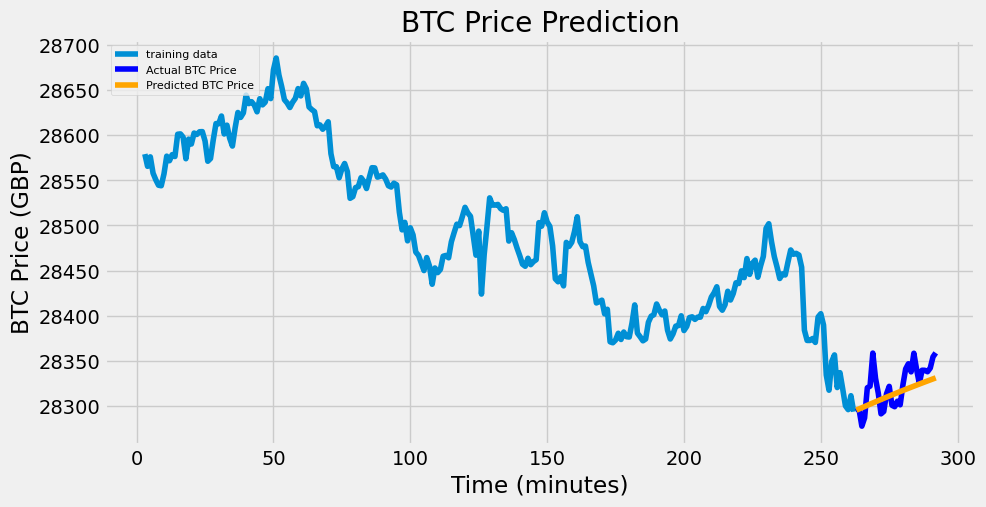

In [14]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual BTC Price')
plt.plot(fc_series, color = 'orange',label='Predicted BTC Price')

plt.title('BTC Price Prediction')
plt.xlabel('Time (minutes)')
plt.ylabel('BTC Price (GBP)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [15]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 387.2527402051062
MAE: 16.315490180376823
RMSE: 19.678738277773455
MAPE: 0.0005758850055867463


The Mean Absolute Percentage Error (MAPE) is very low, implying that the model is predicting the last 30 prices very well.